In [1]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

In [2]:
import spacy
import nltk
import string
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/lolu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
df = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_test_label = pd.read_csv('data/test_labels.csv')

The strategy here is spliting training into tran and validation and test it with df_test.

In [4]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

## 0. Convert to binary outcome

In [5]:
def changBinary(x):
    if x['toxic'] == 0 and x['obscene'] == 0 and x['threat']==0 and x['insult']==0 and x['identity_hate']==0:
        return 0
    else:
        return 1

In [6]:
df['target'] = df.apply(lambda x:changBinary(x), axis=1)

In [7]:
df['target'].value_counts()

0    143346
1     16225
Name: target, dtype: int64

## 1. Clean the text

we clean the text by get rid of the non-string characters in the words.

In [8]:
def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text. Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3, strip digits.
    """
    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if (len(w) > 2)]  # ignore a, an, to, at, be, ...
    return tokens

In [11]:
X = [tokenize(row) for row in df['comment_text'].values]
y = df['target'].values

In [5]:
df_clean = pd.read_csv('data/train_clean.csv')

## 2. Word2Vec

This part shows the process of Word2Vec. We first create a dict containing all the uniqe words appearing in the comment, and then treat it as a categorical variables. Adding "UKN" to handle the words that not in traing set. 

### 2.1 create a word_dic containing all the unique word with k=word, v=frequency

In [12]:
def get_vocab(content):
    """
    Computes the number of times a word is on a document.
    """
    vocab = defaultdict(float)
    for row in content:
        # get unique words
        words = set(row)
        for word in words:
            vocab[word] += 1
    return vocab  

def del_rare(count_dict, min_fqc=5):
    """
    Deletes words from word_count if they don't have at least min_df occurrencies in word_count.
    """
    words_delete = []
    for word in count_dict.keys():
        if count_dict[word] < min_fqc:
            words_delete.append(word)
    for word in words_delete: 
        count_dict.pop(word)
    return count_dict

In [13]:
word_count_dict = get_vocab(X)
word_count_dict = del_rare(word_count_dict, min_fqc=5)

In [14]:
len(word_count_dict)

34672

In [15]:
# create word2vec by word_dict
word2index = {"<pad>":0, "UNK":1}
words = ["<PAD>", "UNK"]
for word in word_count_dict:
    word2index[word] = len(words)
    words.append(word)

### 2.2 Encode sentence uding word2vec_dict (use number to represent sentence)

In [16]:
X_lenght = np.array([len(w) for w in X])

In [17]:
np.percentile(X_lenght,80) # choose 100 as the cut off point

70.0

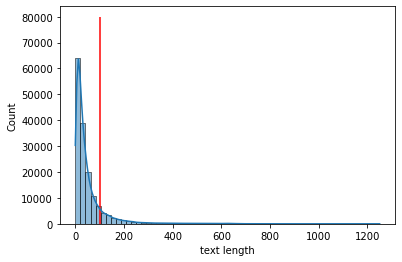

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(X_lenght, bins=60, kde=True)
plt.xlabel('text length')
plt.vlines(100, 0, 80000, color = 'red')
plt.show()

In [19]:
def encode_sentence(s, N, vocab2index):
    encode_out = np.zeros(N, dtype=np.int32)
    encode_len = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in s])
    lenght = min(N, len(encode_len))
    encode_out[:lenght] = encode_len[:lenght]
    return encode_out, lenght

In [20]:
X_encode = np.vstack([encode_sentence(row, 100, word2index) for row in X])

In [21]:
# train-valid split()
X_train, X_valid, y_train, y_valid = train_test_split(X_encode, y, test_size=0.2)

In [22]:
sum(y_train==0), sum(y_train==1), sum(y_valid==0), sum(y_valid==1)

(114746, 12910, 28600, 3315)

In [28]:
class IMDBDataset(Dataset):
    def __init__(self, df, label, word_dict=0, max_length=0):
        self.df = df
        self.label = label
        #self.word_dict = word_dict
        #self.sent_dict = {'negative': 0, 'positive': 1}
        #self.max_len = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df[idx]
        
        x = torch.tensor(row[0])
        
       
            
        y = torch.tensor(self.label[idx]).float()
        
        # embedding likes long tensors
        return x.long(), y
ds = IMDBDataset(X_train, y_train)
next(iter(ds))

(tensor([  281,    97,   180,   272, 19740,   963,    39,   110,     3,   504,
           126,  4324,    25,   901,   108,  2504,   867,   116,    89,    49,
             2, 18570,   108,   953,   157,  1505,    39,   110,   154,   144,
          1540,  1385, 19445,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor(0.))

In [34]:
# Load tiny data into data loader for batching
batch = 100
train_dl = DataLoader(IMDBDataset(X_train, y_train), batch_size=batch, shuffle=True)
valid_dl = DataLoader(IMDBDataset(X_valid, y_valid), batch_size=batch, shuffle=False)

In [29]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
        
    for x, y in dataloader:
        y_pred = (torch.sigmoid(model(x)) > 0.5).float()
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [41]:
class CBOW(nn.Module):
    def __init__(self, dict_length, embedding_size):
        super(CBOW, self).__init__()
        # padding index turns off gradient for unknown tokens
        self.word_emb = nn.Embedding(dict_length, embedding_size, padding_idx=0)
        self.linear = nn.Linear(embedding_size, 1)
        self.emb_size = embedding_size
        
    def forward(self, x):
        sent_length = x.shape[1]
        x = self.word_emb(x)
        with torch.no_grad():
            sent_length = torch.count_nonzero(x, dim=1)
        x = torch.sum(x, dim=1) / sent_length
        x = self.linear(x)
        return torch.squeeze(x)

In [42]:
cbow_model = CBOW(len(word2index), 100)
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cbow_model.parameters(), lr = 0.001)

num_epochs = 5


train_losses = []
valid_losses = []

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    train_loss = one_pass(cbow_model, train_dl, optimizer, lossFun)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(cbow_model, valid_dl, optimizer, lossFun, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(cbow_model, train_dl, len(X_train))
    valid_acc = one_pass_acc(cbow_model, valid_dl, len(X_valid))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/1277 [00:00<?, ?it/s]

Train loss:  nan


  0%|          | 0/320 [00:00<?, ?it/s]

Valid loss:  nan
Train Acc:  0.8988688349940465
Valid Acc:  0.8961303462321792
Epoch:  1


  0%|          | 0/1277 [00:00<?, ?it/s]

Train loss:  nan


  0%|          | 0/320 [00:00<?, ?it/s]

Valid loss:  nan
Train Acc:  0.8988688349940465
Valid Acc:  0.8961303462321792
Epoch:  2


  0%|          | 0/1277 [00:00<?, ?it/s]

Train loss:  nan


  0%|          | 0/320 [00:00<?, ?it/s]

Valid loss:  nan
Train Acc:  0.8988688349940465
Valid Acc:  0.8961303462321792
Epoch:  3


  0%|          | 0/1277 [00:00<?, ?it/s]

Train loss:  nan


  0%|          | 0/320 [00:00<?, ?it/s]

Valid loss:  nan
Train Acc:  0.8988688349940465
Valid Acc:  0.8961303462321792
Epoch:  4


  0%|          | 0/1277 [00:00<?, ?it/s]

Train loss:  nan


  0%|          | 0/320 [00:00<?, ?it/s]

Valid loss:  nan
Train Acc:  0.8988688349940465
Valid Acc:  0.8961303462321792
